<h1>1.4 - Interpretability and Generalization</h1>

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PilotLeoYan/inside-deep-learning/blob/main/1-linear-regression/1-4-interpretability-generalization.ipynb">
    <img src="../images/colab_logo.png" />Open in Google Colab</a>
  </td>
</table>

We have already seen the math that makes our linear regression work. 
But there are two questions to better understand how the model works.

1. How does the model work?
2. How well does the model work?

The first question explores how the model works to transform inputs into outputs, 
and the second question explores the performance of the model.

In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image

from platform import python_version
python_version(), torch.__version__

('3.13.2', '2.6.0+cu126')

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
device

'cuda'

# Dataset

## create dataset

In [3]:
M: int = 10_101 # number of samples
x_start: float = -4
x_end: float = 4

In [4]:
torch.manual_seed(0)
X = torch.linspace(start=x_start, end=x_end, steps=M, device=device)[torch.randperm(M)].unsqueeze(dim=-1)
X.shape

torch.Size([10101, 1])

In [5]:
def make_regression(input: torch.Tensor, noise: float = 1) -> torch.Tensor:
    true_w: list[float] = [1, -2, 3]
    true_b: float = 5

    y = torch.full_like(input, true_b) + torch.normal(0, noise, size=input.shape, device=input.device)
    for p, w in enumerate(true_w, start=1):
        y += input.pow(p) * w
    return y

In [6]:
Y = make_regression(X, noise=2)
Y.shape

torch.Size([10101, 1])

## split dataset

Unlike the past notebooks, we are going to separate the dataset into two parts, 
the first part is the **learning set** and the second part is the **test set**. 
The learning set will be used for model selection, training and validation. 
We will separate this set into the **training** and **validation** set when we run cross-validation and train our model. 
We will use the test set to measure the generalization of our final model. 
This way, from now on, we will not be able to make any decisions based on the test set that may bias us in the development of our model.

In [7]:
def split_dataset(x: torch.Tensor, y: torch.Tensor, 
                  train: float = 0.8) -> list[torch.Tensor]:
    """
    Split a dataset into two parts: training set, test set. 
    
    Args:
        x: The input tensor to be split.
        y: The output tensor to be split.
        train: Proportion of the data for training. Defaults to 0.8.
        
    Returns:
        list: [input training set, input test set, output training set, output test set].
    
    Example: 
        train_set, test_set = split_dataset(X, Y)
    """
    if len(x) != len(y):
        raise Exception(f'len(x) = {len(x)} is not same len(y) = {len(y)}.')

    n_samples: int = len(x)
    train_split: int = int(n_samples * train)

    return x[:train_split], x[train_split:], y[:train_split], y[train_split:]

In [8]:
X_learn, X_test, Y_learn, Y_test = split_dataset(X, Y, 0.01)
X_learn.shape, X_test.shape, Y_learn.shape, Y_test.shape

(torch.Size([101, 1]),
 torch.Size([10000, 1]),
 torch.Size([101, 1]),
 torch.Size([10000, 1]))

## delete raw dataset

In [9]:
del X, Y

## plot train dataset

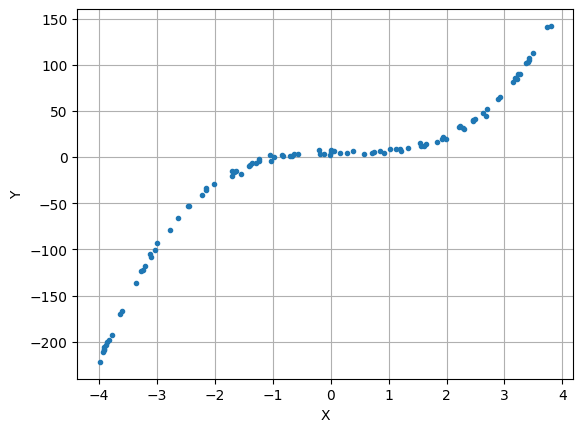

In [10]:
plt.plot(X_learn.cpu().numpy(), Y_learn.cpu().numpy(), '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

# Polynomial regression

In essence, polynomial regression is the same as linear regression. 
The only difference is that we (the developer) are going to manually increase the number of input features.

For example, if we have the input data $\mathbf{X}$ as
$$
\mathbf{X} = \begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22} \\
    x_{31} & x_{32}
\end{bmatrix}
$$

We can increase $\mathbf{X}$ in degree as
$$
\hat{\mathbf{X}}_{3} = \begin{bmatrix}
    x_{11} & x_{12} & x_{11}^{2} & x_{12}^{2} \\
    x_{21} & x_{22} & x_{21}^{2} & x_{22}^{2} \\
    x_{31} & x_{32} & x_{31}^{2} & x_{32}^{2}
\end{bmatrix}
$$
Our linear regression model will not know that it is working on a polynomial.

**Remark**: The model does not decide to what degree the input will be increased. 
Therefore, the degree of the polynomial will be a hyperparameter controlled by the developer.

## Torch model initialization

In [11]:
class PolyRegression(nn.Module):
    def __init__(self, n_out_features: int, degree: int, lambd: float):
        super(PolyRegression, self).__init__()

        self.degree = degree # polynomial dregree
        self.lambd = lambd # weight decay
        self.layer = nn.Linear(self.degree, n_out_features, device=device)
        self.loss = nn.MSELoss()

    def set_params(self, new_bias: torch.Tensor, new_weight: torch.Tensor) -> None:
        if self.layer.bias.shape != new_bias.shape:
            raise Exception(f'old_bias {self.layer.bias.shape} is no same new_bias {new_bias.shape}')
        if self.layer.weight.shape != new_weight.shape:
            raise Exception(f'old_weight {self.layer.weight.shape} is no same new_weight {new_weight.shape}')

        with torch.no_grad():
            self.layer.bias *= 0
            self.layer.bias += new_bias

            self.layer.weight *= 0
            self.layer.weight += new_weight

    def polynomial_features(self, a: torch.Tensor) -> torch.Tensor:
        expanded = torch.cat([a.pow(i) for i in range(1, self.degree + 1)], dim=1)
        return expanded
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(self.polynomial_features(x))
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            return self.forward(x)

    def evaluate(self, x: torch.Tensor, y: torch.Tensor) -> float:
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x)
            return self.loss(y_pred, y).item()
        
    def plot(self, x: torch.Tensor, y: torch.Tensor,
             ax = None, title: None|str = None, suptitle: None|str = None) -> None:

        x_min, x_max = torch.min(x), torch.max(x)
        x_linspace = torch.linspace(start=x_min, end=x_max, steps=150, device=x.device).unsqueeze(-1)
        y_pred = self.predict(x_linspace)

        if ax is not None:
            ax.clear()
            ax.plot(x.cpu().numpy(), y.cpu().numpy(), '.', label='Data')
            ax.set_xlim(x_min.item() - 0.5, x_max.item() + 0.5)
            ax.set_ylim(y.min().item() - 0.5, y.max().item() + 0.5)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.grid(True)
            if title is not None:
                ax.set_title(label=title, fontsize=10)
            ax.plot(x_linspace.cpu().numpy(), y_pred.cpu().numpy(), label='Predict')
            #ax.legend()
            return

        plt.plot(x.cpu().numpy(), y.cpu().numpy(), '.', label='Data')
        plt.xlim(x_min.item() - 0.5, x_max.item() + 0.5)
        plt.ylim(y.min().item() - 0.5, y.max().item() + 0.5)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        if title is not None:
            plt.title(label=title, fontsize=10)
        if suptitle is not None:
            plt.suptitle(suptitle)
        plt.plot(x_linspace.cpu().numpy(), y_pred.cpu().numpy(), label='Predict')
        plt.legend()
        plt.show()

    def bias_var(self, pred, true) -> tuple[float, float]:
        def bias(pred, true):
            return torch.mean(pred - true).square().item()

        def var(a):
            return torch.var(a, unbiased=False).item()
        
        return bias(pred, true), var(pred - true)
    
    def fit(self, x, y, epochs, lr, batch_size, x_valid, y_valid, verbose=True, plot=True):

        optimizer = torch.optim.SGD([
            {'params': self.layer.weight, 'weight_decay': self.lambd},
            {'params': self.layer.bias} # it is important to specify the weight decay for the bias.
        ], lr=lr)

        if plot:
            fig, ax = plt.subplots()
            fig.suptitle('Polynomial regression training')

        self.train_loss = [] 
        self.valid_loss = []

        self.bias_train = []
        self.var_train = []
        self.bias_valid = []
        self.var_valid = []

        def add_bias_var():
            y_pred = self.predict(x)
            bias, var = self.bias_var(y_pred, y)
            self.bias_train.append(bias)
            self.var_train.append(var)

            y_pred = self.predict(x_valid)
            bias, var = self.bias_var(y_pred, y_valid)
            self.bias_valid.append(bias)
            self.var_valid.append(var)

        def update(epoch):
            if epoch == 0:
                # plot initial model
                self.train_loss.append(round(self.evaluate(x, y), 4))
                self.valid_loss.append(round(self.evaluate(x_valid, y_valid), 4))
                add_bias_var()

                if verbose:
                    print(f'init model - MSE: {self.train_loss[-1]} - MSE_v: {self.valid_loss[-1]}')
                if plot:
                    self.plot(x, y, ax, title=f'Init model - MSE: {self.train_loss[-1]} - MSE_v: {self.valid_loss[-1]}')
                return
            
            temp_loss_t = []
            for batch in range(0, len(y), batch_size):
                end_batch = batch + batch_size

                y_pred = self.forward(x[batch:end_batch])
                loss = self.loss(y_pred, y[batch:end_batch])
                temp_loss_t.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            self.train_loss.append(round(sum(temp_loss_t) / len(temp_loss_t), 4))
            self.valid_loss.append(round(self.evaluate(x_valid, y_valid), 4))
            add_bias_var()

            if verbose:
                print(f'epoch: {epoch} - MSE: {self.train_loss[-1]} - MSE_v: {self.valid_loss[-1]}')
            if plot:
                self.plot(x, y, ax, title=f'Epoch: {epoch} - MSE: {self.train_loss[-1]} - MSE_v: {self.valid_loss[-1]}')

        if plot:     
            ani = FuncAnimation(fig, update, frames=epochs + 1, repeat=False)
            ani.save('test-linear_regression.gif', fps=5)
            plt.close()
            display(Image(filename='./test-linear_regression.gif'))
        else:
            for epoch in range(epochs + 1):
                update(epoch)

        self.train_loss.pop(0)
        self.valid_loss.pop(0)

        self.bias_train.pop(0)
        self.var_train.pop(0)
        self.bias_valid.pop(0)
        self.var_valid.pop(0)

# MAP

Maximum a posteriori estimation (MAP) is a way to estimate the parameters 
in a single mathematical calculation, without having to use gradient descent iteratively.
It can be obtained by solving the derivative of the objective function equal to 0.

**Remark**: This way of estimating parameters is not used for large data sets because calculating the inverse of a matrix is expensive.

If we use MSE as a loss function and $\ell_2$ as a regularizer.

$$
\mathbf{\Theta} = \begin{bmatrix}
    b_{1} & b_{2} & \cdots & b_{n_{1}} \\
    w_{11} & w_{12} & \cdots & w_{1 n_{1}} \\
    w_{21} & w_{22} & \cdots & w_{2 n_{1}} \\
    \vdots & \vdots & \ddots & \vdots \\
    w_{n1} & w_{n2} & \cdots & w_{n n_{1}}
\end{bmatrix} \in \mathbb{R}^{(n+1) \times n_{1}}
$$

$$
\hat{\mathbf{X}} = \begin{bmatrix}
    1 & x_{11} & x_{12} & \cdots & x_{1n} \\
    1 & x_{21} & x_{22} & \cdots & x_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & x_{m1} & x_{m2} & \cdots & x_{mn}
\end{bmatrix} \in \mathbb{R}^{m \times (n + 1)}
$$

$$
\frac{\partial J}{\partial \mathbf{\Theta}} = 
(\hat{\mathbf{X}})^\top 
\left(\hat{\mathbf{X}} \mathbf{\Theta - Y} \right)
+ \lambda \mathbf{\Theta} = \mathbf{0} \\
(\hat{\mathbf{X}})^\top \hat{\mathbf{X}} \mathbf{\Theta}
-(\hat{\mathbf{X}})^\top \mathbf{Y}
+ \lambda \mathbf{\Theta} = \mathbf{0} \\
(\hat{\mathbf{X}})^\top \hat{\mathbf{X}} \mathbf{\Theta}
+ \lambda \mathbf{\Theta} = (\hat{\mathbf{X}})^\top \mathbf{Y} \\
\mathbf{\Theta} \left( (\hat{\mathbf{X}})^\top \hat{\mathbf{X}}
+ \lambda \boldsymbol{I} \right) = (\hat{\mathbf{X}})^\top \mathbf{Y} \\
\mathbf{\Theta} = \left( (\hat{\mathbf{X}})^\top \hat{\mathbf{X}}
+ \lambda \boldsymbol{I} \right)^{-1}
(\hat{\mathbf{X}})^\top \mathbf{Y}
$$

**Note**: If the regularization parameter $\lambda = 0$, 
then we are doing Maximum Likelihood Estimate (MLE).

**Remark**: We are assuming that bias $\mathbf{b}$ 
is also going to be regulated by $\ell_2$.

In [12]:
def map(x: torch.Tensor, y: torch.Tensor, lambd: float):
    """Maximum a posteriori estimation (MAP)."""
    x_exp = torch.cat([torch.ones((len(x), 1), device=x.device), x], dim=1)
    lambd_ = lambd * torch.eye(x_exp.shape[-1], device=device)
    theta = torch.inverse(x_exp.T @ x_exp + lambd_) @ x_exp.T @ y
    return theta[0, :], theta[1:, :] # bias, weight

# Cross-validation

A common technique for working with a new dataset is **cross-validation** which consists of: 
trying as many different models as possible, and evaluating their results. 
Then, select a model that shows the best results.

Cross-validation is used to estimate the generalizability of a model without having to use the test set.

## k-fold cross validation

In [13]:
def k_fold_cv(model: PolyRegression, x: torch.Tensor, 
              y: torch.Tensor, k_folds: int) -> torch.Tensor:
    
    m: int = len(y) // k_folds
    
    left, right = 0, m
    loss_v = torch.zeros(size=(k_folds,), dtype=torch.float32, device=x.device)

    for k in range(k_folds):
        x_v, y_v = x[left:right], y[left:right] # valid fold
        x_t = torch.cat((x[:left], x[right:])) # x train fold
        y_t = torch.cat((y[:left], y[right:])) # y train fold

        theta = map(model.polynomial_features(x_t), y_t, model.lambd)
        model.set_params(theta[0], theta[1].T)

        loss_v[k] += model.evaluate(x_v, y_v)
        
        left, right = left + m, right + m
    
    return torch.mean(loss_v)

Here, we will train multiple models with varying degrees of input. 
For this example, we will different values of $\lambda$ and
use polynomial degrees from 1 to 6.
$$
\text{try with } \lambda \in \{0.001, 0.01, 0.1, 1, 100, 1000 \} \\
\text{and} \\
\text{try with} \left\{
    \mathbf{X}, \hat{\mathbf{X}}_{2},
    \hat{\mathbf{X}}_{3}, \hat{\mathbf{X}}_{4},
    \hat{\mathbf{X}}_{5}, \hat{\mathbf{X}}_{6}
\right\}
$$

In [14]:
lambd: tuple[float] = (1e-3, 1e-2, 1e-1, 1, 1e2, 1e3) # penalty term
degree: tuple[int] = (1, 2, 3, 4, 5, 6) # degree of the polynomial

k_folds: int = 5 # number of folds

mean_cv = torch.zeros(len(degree), len(lambd), dtype=torch.float32, device=device)

torch.manual_seed(0)

for degree_, mean_row in zip(degree, mean_cv):
    print(f'degree = {degree_} ', end='')

    for lamdb_, mean_ in zip(lambd, mean_row):
        model = PolyRegression(Y_learn.shape[-1], degree=degree_, lambd=lamdb_)

        res_mean = k_fold_cv(model, X_learn, Y_learn, k_folds)
            
        mean_ += res_mean
        print('█', end='')
    print()

degree = 1 ██████
degree = 2 ██████
degree = 3 ██████
degree = 4 ██████
degree = 5 ██████
degree = 6 ██████


## results

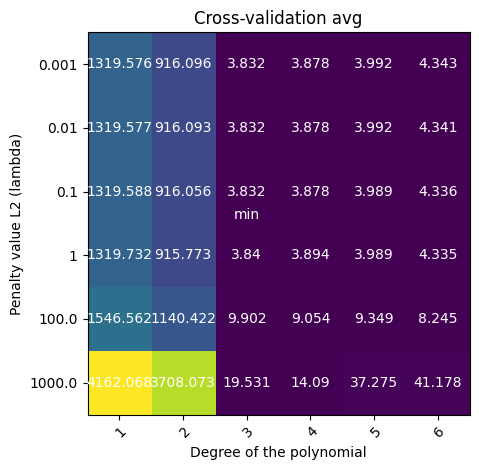

In [15]:
fig, ax = plt.subplots()

min_x, min_y = torch.where(mean_cv == torch.min(mean_cv))
data = mean_cv.cpu().numpy()

im = ax.imshow(data.T)

ax.set_xticks(range(len(degree)), labels=degree,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(lambd)), labels=lambd)

ax.set_title('Cross-validation avg')
ax.set_ylabel('Penalty value L2 (lambda)')
ax.set_xlabel('Degree of the polynomial')

for i in range(len(degree)):
    for j in range(len(lambd)):
        text = ax.text(i, j, round(data[i, j], 3),
                    ha="center", va="center", color="w")
ax.text(min_x.item(), min_y.item(), '\nmin', ha="center", va="top", color='w')

fig.tight_layout()
plt.show()

del data

In [16]:
DEGREE: int = degree[min_x]
LAMBDA: float = lambd[min_y]

del min_x, min_y
DEGREE, LAMBDA

(3, 0.1)

# Interpretability

**Interpretability** often attempts to answer the question "How does the model work?".
Interpreting linear regression operations is easy for a human. 
So, let's see with an animation how our model is trained on the training data.

## model init

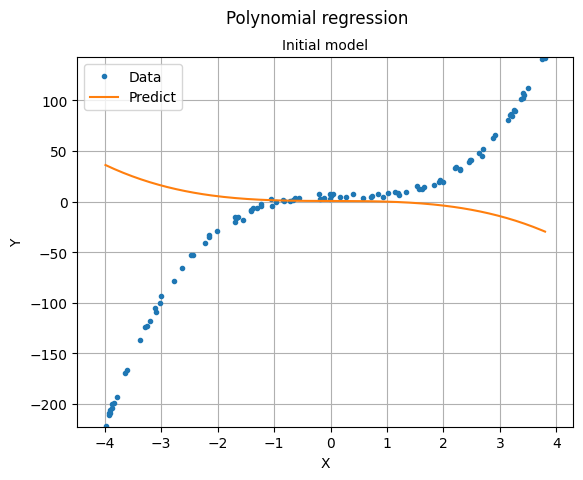

In [17]:
torch.manual_seed(0)

model = PolyRegression(
    n_out_features=Y_learn.shape[-1],
    degree=DEGREE,
    lambd=LAMBDA
)

model.plot(X_learn, Y_learn, title='Initial model', suptitle='Polynomial regression')

## training

In [18]:
X_train, X_valid, Y_train, Y_valid = split_dataset(X_learn, Y_learn)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

(torch.Size([80, 1]),
 torch.Size([21, 1]),
 torch.Size([80, 1]),
 torch.Size([21, 1]))

In [19]:
LR = 1e-5 # learning rate
EPOCHS = 35 # number of epochs
BATCH = 1 # batch size

MovieWriter ffmpeg unavailable; using Pillow instead.


init model - MSE: 11804.3389 - MSE_v: 3116.4819
init model - MSE: 11804.3389 - MSE_v: 3116.4819
epoch: 1 - MSE: 4433.3983 - MSE_v: 131.6935
epoch: 2 - MSE: 380.4234 - MSE_v: 19.7578
epoch: 3 - MSE: 76.4996 - MSE_v: 31.0847
epoch: 4 - MSE: 45.4084 - MSE_v: 33.5509
epoch: 5 - MSE: 37.4436 - MSE_v: 31.7032
epoch: 6 - MSE: 32.6836 - MSE_v: 29.071
epoch: 7 - MSE: 28.997 - MSE_v: 26.6078
epoch: 8 - MSE: 25.9759 - MSE_v: 24.4947
epoch: 9 - MSE: 23.4655 - MSE_v: 22.7243
epoch: 10 - MSE: 21.371 - MSE_v: 21.2513
epoch: 11 - MSE: 19.6213 - MSE_v: 20.0289
epoch: 12 - MSE: 18.159 - MSE_v: 19.0153
epoch: 13 - MSE: 16.9363 - MSE_v: 18.1756
epoch: 14 - MSE: 15.9136 - MSE_v: 17.4802
epoch: 15 - MSE: 15.0579 - MSE_v: 16.9047
epoch: 16 - MSE: 14.3416 - MSE_v: 16.4285
epoch: 17 - MSE: 13.7417 - MSE_v: 16.035
epoch: 18 - MSE: 13.239 - MSE_v: 15.7096
epoch: 19 - MSE: 12.8174 - MSE_v: 15.4409
epoch: 20 - MSE: 12.4635 - MSE_v: 15.219
epoch: 21 - MSE: 12.1662 - MSE_v: 15.0358
epoch: 22 - MSE: 11.9162 - MSE_v: 

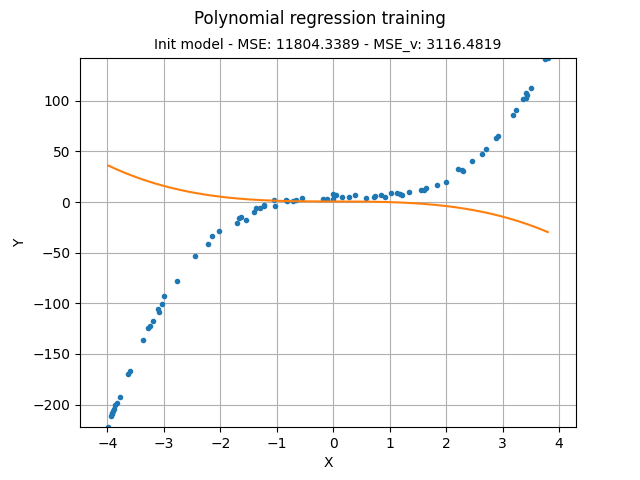

In [20]:
model.fit(
    X_train, Y_train,
    EPOCHS, LR, BATCH,
    X_valid, Y_valid
)

## model loss descent

MovieWriter ffmpeg unavailable; using Pillow instead.


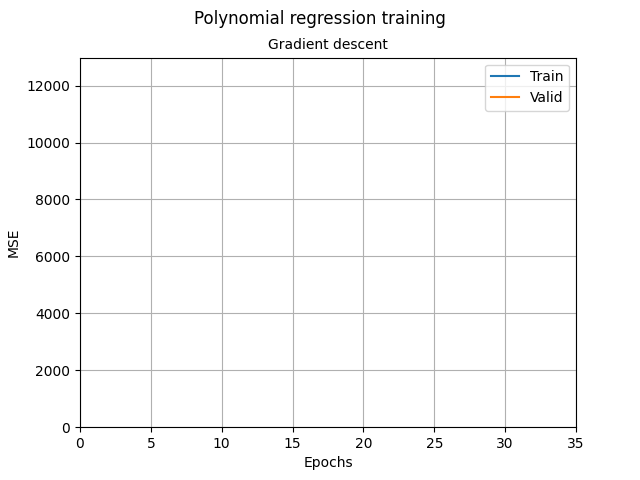

In [21]:
fig, ax = plt.subplots()
fig.suptitle('Polynomial regression training')
ax.set_title('Gradient descent', fontsize=10)
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.grid(True)
ax.set_xlim(0, len(model.train_loss) - 1)
ax.set_ylim(0, max(model.train_loss + model.valid_loss) * 1.1 if model.train_loss and model.valid_loss else 1)

line_t, = ax.plot([], [], label='Train')
line_va, = ax.plot([], [], label='Valid')
ax.legend()

def update_loss(frame):
    line_t.set_data(range(frame + 1), model.train_loss[:frame + 1])
    line_va.set_data(range(frame + 1), model.valid_loss[:frame + 1])
    return line_t, line_va

ani_loss = FuncAnimation(fig, update_loss, frames=len(model.train_loss), repeat=False)
ani_loss.save('test-loss_evolution.gif', fps=2)
plt.close()
display(Image(filename='./test-loss_evolution.gif'))

# Generalization

Generalization attempt to answer "How well does the model work?". 
Here we evaluate how well the models are able to approximate outputs to previously unseen inputs. 
Then, we are going to perform different tests to measure its level to generalize the dataset.

## generalization error

It is impossible to measure the generalization error $R$ of our model because we need an infinite dataset.

$$
R[p, f] = \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim P}
\left[ L \left( \hat{f}(\mathbf{x}), \mathbf{y} \right) \right] =
\int \int L \left( \hat{f}(\mathbf{x}), \mathbf{y} \right)
p(\mathbf{x}, \mathbf{y}) d\mathbf{x} d\mathbf{y}
$$

All we can do is estimate R with the test set, assuming that this set is i.i.d.

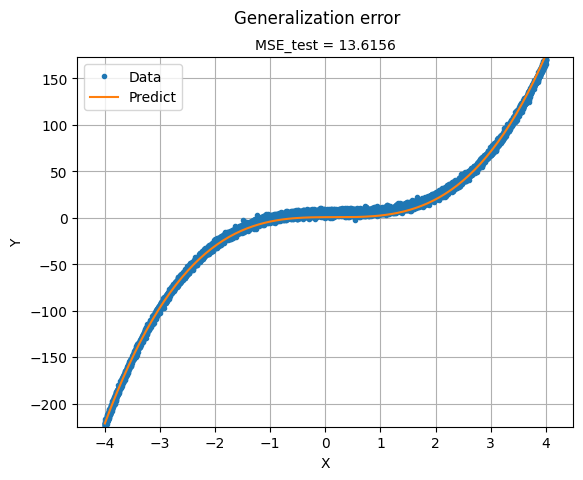

In [22]:
model.plot(X_test, Y_test, 
           title=f'MSE_test = {model.evaluate(X_test, Y_test):.4f}', 
           suptitle='Generalization error'
)

## number of samples in test set

The number of samples in our test set matters. 
If we estimate the generalization error from several different samples, 
we can see how the estimate varies depending on which samples we take.

In [23]:
loss_test_1: list[float] = []
loss_test_2: list[float] = []
loss_test_3: list[float] = []

p = torch.randperm(len(X_test))
x_test_r, y_test_r = X_test[p], Y_test[p]

for i in range(100, len(X_test) + 1, 100):
    loss_test_1.append(round(model.evaluate(X_test[:i], Y_test[:i]), 4))
    loss_test_2.append(round(model.evaluate(X_test[-i:], Y_test[-i:]), 4))
    loss_test_3.append(round(model.evaluate(x_test_r[:i], y_test_r[:i]), 4))

del p, x_test_r, y_test_r

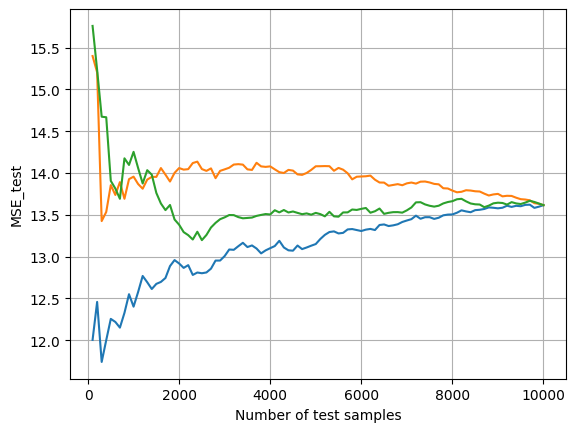

In [24]:
plt.plot(range(100, len(X_test) + 1, 100), loss_test_1)
plt.plot(range(100, len(X_test) + 1, 100), loss_test_2)
plt.plot(range(100, len(X_test) + 1, 100), loss_test_3)
plt.grid(True)
plt.xlabel('Number of test samples')
plt.ylabel('MSE_test')
plt.show()
del loss_test_1, loss_test_2, loss_test_3

**Note**: The 3 ways we chose to sample the test set end up in the same error because 
the whole set is being selected, but this is not the exact generalization error.

## bayes error

Although Bayes error is more specific to classification, 
we will take this concept for regression. 
Can a model have 0 generalization error? 
Well, it is possible if the problem is free of irreducible error, 
otherwise, even if the model can learn the true relationship between $\mathbf{X}$ and $\mathbf{Y}$, 
there is an error that cannot be reduced due to noise.

If we adjust the model parameters with the true bias and weight used to generate 
$\mathbf{Y}$ from $\mathbf{X}$, 
we can see that even this model has error in the test set.

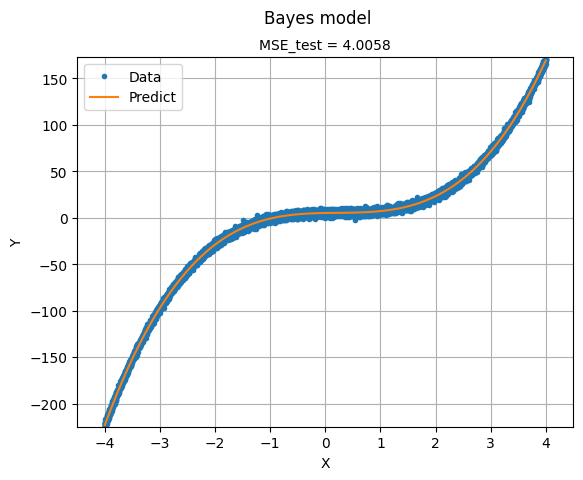

In [25]:
bayes_model = PolyRegression(Y_train.shape[-1], 3, 0)
# true bias and true weight
theta = torch.tensor([5.0], device=device), torch.tensor([[1, -2, 3.0]], device=device)
bayes_model.set_params(theta[0], theta[1])
bayes_model.plot(X_test, Y_test, 
           title=f'MSE_test = {bayes_model.evaluate(X_test, Y_test):.4f}', 
           suptitle='Bayes model'
)

## underfitting and overfitting

The capability of a model describes the ability to represent relationships. 
A linear regression model will only be able to represent linear relationships, 
while a degree 2 polynomial regression model will be able to represent both degree 2 and linear polynomial relationships.

Then it is important to choose a good capacity for our model, 
a low one and our model will not be able to represent the relationship, 
and a very high one will be able to represent the relationship and represent the noise, 
therefore its generalization will be poor.

**Note**: The capability can also be called “Model Complexity”. It is recommended to investigate “The VC dimension”.

### underfit model

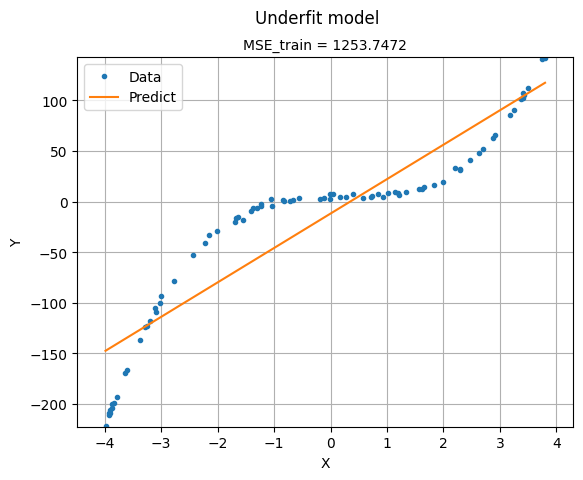

In [26]:
under_model = PolyRegression(Y_train.shape[-1], 1, 0)
theta = map(under_model.polynomial_features(X_train), Y_train, under_model.lambd)
under_model.set_params(theta[0], theta[1].T)
under_model.plot(X_train, Y_train, 
                 title=f'MSE_train = {under_model.evaluate(X_train, Y_train):.4f}',
                 suptitle='Underfit model'
)

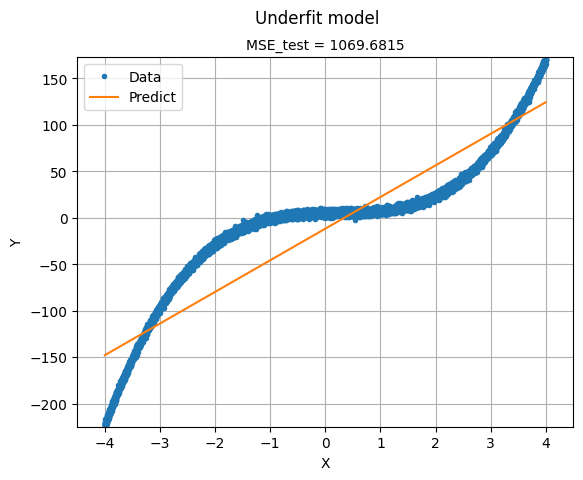

In [27]:
under_model.plot(X_test, Y_test, 
                 title=f'MSE_test = {under_model.evaluate(X_test, Y_test):.4f}',
                 suptitle='Underfit model'
)

### overfit model

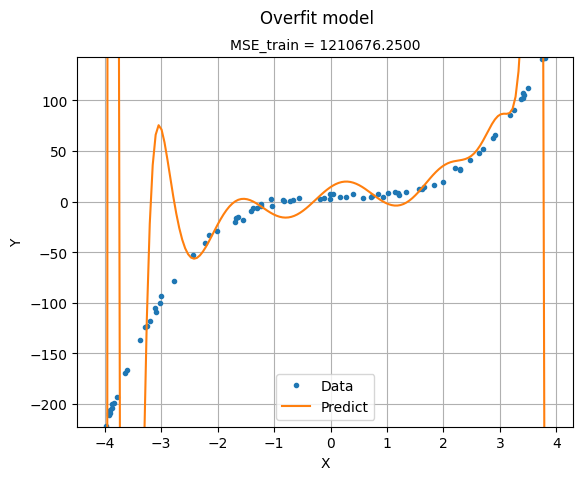

In [28]:
over_model = PolyRegression(Y_train.shape[-1], 30, 0)
theta = map(over_model.polynomial_features(X_train), Y_train, over_model.lambd)
over_model.set_params(theta[0], theta[1].T)
over_model.plot(X_train, Y_train,
                 title=f'MSE_train = {over_model.evaluate(X_train, Y_train):.4f}',
                 suptitle='Overfit model'
)

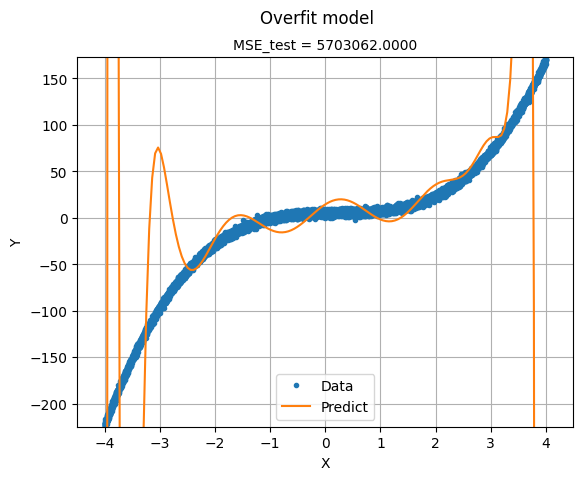

In [29]:
over_model.plot(X_test, Y_test,
                 title=f'MSE_test = {over_model.evaluate(X_test, Y_test):.4f}',
                 suptitle='Overfit model'
)

## bias-variance descomposition

When our model minimizes the loss function, 
if we think of the function predicted by the model as $\hat{f}$ and $\mathbf{Y}$ as random variables. 
We can use MSE loss function as:
$$
\text{MSE}(\hat{f}, \mathbf{Y}) = 
\mathbb{E}\left[ \left( \hat{f} - \mathbf{Y} \right)^{2} \right]
$$
where $\mathbf{Y} = f(\mathbf{X}) + \epsilon$, $f$ is the true function and $\epsilon$ is the noise.

Then we can decompose the MSE as follows:
$$
\begin{align}
\text{MSE}(\hat{f}, \mathbf{Y}) &= 
\mathbb{E} \left[ \left( \hat{f} - \mathbf{Y} \right)^{2} \right] \\
&= {\color{Cyan} {\mathbb{E} \left[ \hat{f} - \mathbf{Y} \right]}}^{2}
+ {\color{Orange} {\mathbb{V} \left[ \hat{f} - \mathbf{Y} \right]}} \\
&= {\color{Cyan} {\mathbb{E} \left[ \hat{f} - \mathbf{Y} \right]}}^{2}
+ {\color{Orange} {\mathbb{V} \left[ \hat{f} \right]
+ \mathbb{V} \left[ \mathbf{Y} \right]
-2 \text{Cov} \left[ \hat{f}, \mathbf{Y} \right]}} \\
&= {\color{Cyan} {\text{Bias} \left( \hat{f} \right)}}^{2}
+ {\color{Orange} {\mathbb{V} \left[ \hat{f} \right]
+ \mathbb{V} \left[ \mathbf{Y} \right]
-2 \text{Cov} \left[ \hat{f}, \mathbf{Y} \right]}}
\end{align}
$$
where $\text{Bias} (\hat{f}) = \mathbb{E}[\hat{f} - \mathbf{Y}]$.

Commonly in the literature, only the Bias-Variance Decomposition is specified as how:
$$
\text{MSE}(\hat{f}, \mathbf{Y}) = 
\text{Bias} ( \hat{f} )^{2}
+ \mathbb{V} [ \hat{f} ]
+ \mathbb{V} [ \mathbf{Y} ]
$$
where the Bias term tells us how far our model is from the true data, 
the Variance term of our model tells us how volatile our model is and 
the last term is called “Bayes Error” because it is the noise that cannot be predicted from the inputs.

🔴 We are going to use equation (2) because it captures how the model design attempts to estimate the true function that maps X to Y.

<h3>⚠ Important ⚠</h3>

1. In some works they assume that this relationship of Bias and Variance is inverse. 
This is called “Bias-Variance-tradeoff”, and does not necessarily apply to all models. 
For that reason, here it is called “Bias-Variance-Decomposition”. See References.
2. If you calculate $\mathbb{V}[f]$ you can see that it can change, 
this is because the model (if it can) is trying to mimic the variance of $\mathbf{Y}$.
3. Assuming that $\hat{f}$ and $\mathbf{Y}$ are random variables, therefore the covariance in equation (3) exists. 

### model complexity

#### polynomial degree

In [30]:
bias: list[float] = []
var: list[float] = []
var2: list[float] = []
error: list[float] = []

degree = range(1, 15) # degree of the polynomial

for degree_ in degree:
    submodel = PolyRegression(Y_train.shape[-1], degree_, 0)
    theta = map(submodel.polynomial_features(X_learn), Y_learn, submodel.lambd)
    submodel.set_params(theta[0], theta[1].T)

    y_pred = submodel.predict(X_test)
    bias_, var_ = submodel.bias_var(y_pred, Y_test)

    bias.append(bias_)
    var.append(var_)
    var2.append(torch.var(y_pred, unbiased=False).item())
    error.append(model.loss(y_pred, Y_test).item())

del y_pred, bias_, var_

In [31]:
min_error = min(range(len(error)), key=error.__getitem__)

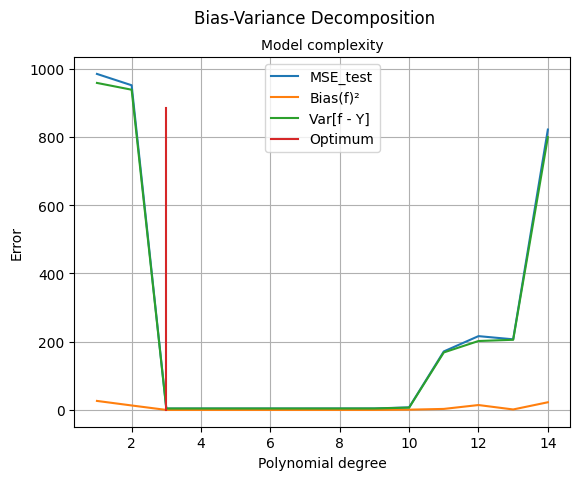

In [32]:
plt.plot(degree, error, label='MSE_test')
plt.plot(degree, bias, label='Bias(f)²')
plt.plot(degree, var, label='Var[f - Y]')
plt.plot([degree[min_error]] * 2, [0, max(error) * .9], label='Optimum')
plt.grid(True)
plt.legend()
plt.title('Model complexity', fontsize=10)
plt.suptitle('Bias-Variance Decomposition')
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.show()

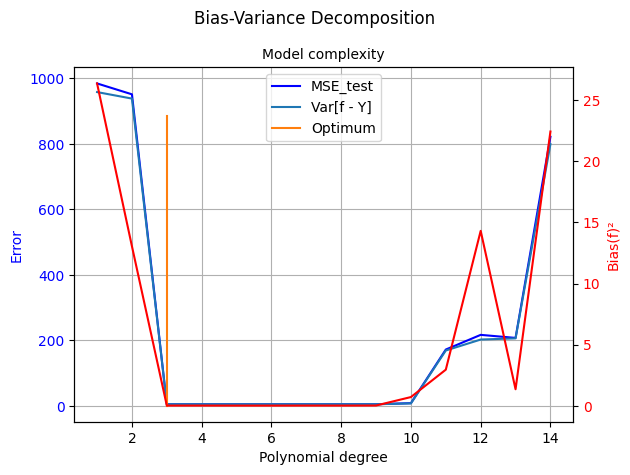

In [ ]:
fig, ax1 = plt.subplots()
fig.suptitle('Bias-Variance Decomposition')
ax1.set_title('Model complexity', fontsize=10)

ax1.plot(degree, error, 'b-', label='MSE_test')
ax1.plot(degree, var, label='Var[f - Y]')
ax1.plot([degree[min_error]] * 2, [0, max(error) * .9], label='Optimum')
ax1.set_xlabel('Polynomial degree')
ax1.set_ylabel('Error', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)
ax1.legend()

ax2 = ax1.twinx()

ax2.plot(degree, bias, 'r-', label='Bias(f)²')
ax2.set_ylabel('Bias(f)²', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

In [34]:
var_y = torch.var(Y_test, unbiased=False).item()
var_y

5658.83740234375

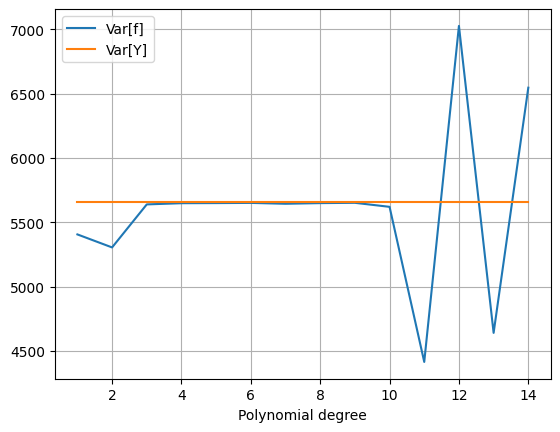

In [35]:
plt.plot(degree, var2, label='Var[f]')
plt.plot([degree[0], degree[-1]], [var_y, var_y], label='Var[Y]')
plt.grid(True)
plt.xlabel('Polynomial degree')
plt.legend()
plt.show()

#### lambda term

In [36]:
bias: list[float] = []
var: list[float] = []
error: list[float] = []

lambd: tuple[float] = (1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4) # penalty term

for lambd_ in lambd:
    submodel = PolyRegression(Y_train.shape[-1], 14, lambd_)
    theta = map(submodel.polynomial_features(X_learn), Y_learn, submodel.lambd)
    submodel.set_params(theta[0], theta[1].T)

    y_pred = submodel.predict(X_test)
    bias_, var_ = submodel.bias_var(y_pred, Y_test)

    bias.append(bias_)
    var.append(var_)
    error.append(model.loss(y_pred, Y_test).item())

del y_pred, bias_, var_

In [37]:
min_error = min(range(len(error)), key=error.__getitem__)

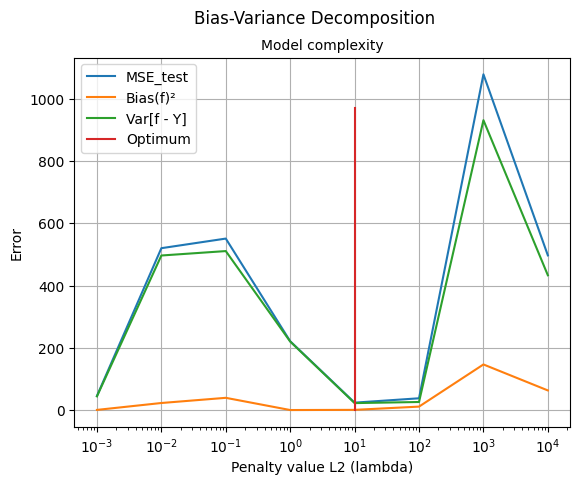

In [38]:
plt.plot(lambd, error, label='MSE_test')
plt.plot(lambd, bias, label='Bias(f)²')
plt.plot(lambd, var, label='Var[f - Y]')
plt.plot([lambd[min_error]] * 2, [0, max(error) * .9], label='Optimum')
plt.grid(True)
plt.legend()
plt.xscale('log')
plt.title('Model complexity', fontsize=10)
plt.suptitle('Bias-Variance Decomposition')
plt.xlabel('Penalty value L2 (lambda)')
plt.ylabel('Error')
plt.show()

### minizing the error during training

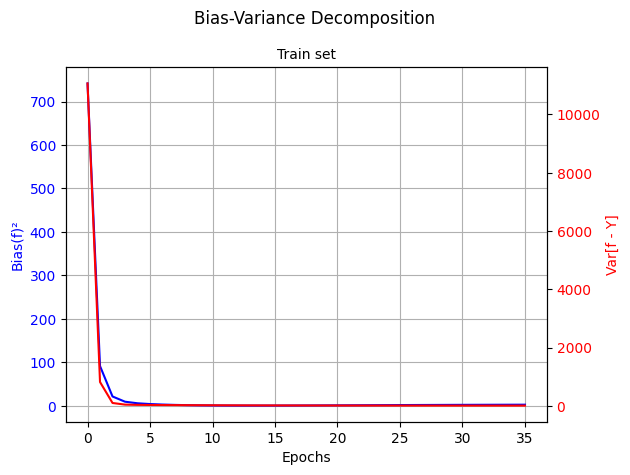

In [39]:
x = range(0, len(model.bias_train))
fig, ax1 = plt.subplots()
fig.suptitle('Bias-Variance Decomposition')
ax1.set_title('Train set', fontsize=10)

ax1.plot(x, model.bias_train, 'b-', label='Bias(f)²')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Bias(f)²', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()

ax2.plot(x, model.var_train, 'r-', label='Var[f - Y]')
ax2.set_ylabel('Var[f - Y]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

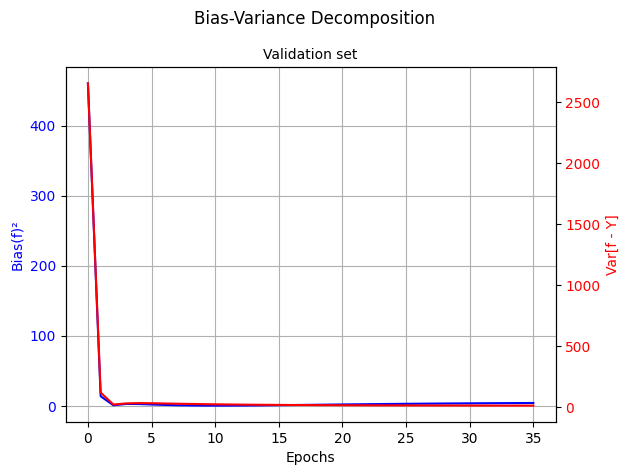

In [40]:
x = range(0, len(model.bias_valid))
fig, ax1 = plt.subplots()
fig.suptitle('Bias-Variance Decomposition')
ax1.set_title('Validation set', fontsize=10)

ax1.plot(x, model.bias_valid, 'b-', label='Bias(f)²')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Bias(f)²', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()

ax2.plot(x, model.var_valid, 'r-', label='Var[f - Y]')
ax2.set_ylabel('Var[f - Y]', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

# References

[A Review of Techniques for Regularization]
- [[URL]](https://www.researchgate.net/publication/367546346_A_Review_of_Techniques_for_Regularization/citation/download)
- *Jecinta, Ibebuike and Obi, Jude*
- `2023`

[Bias-Variance Analysis: Theory and Practice]
- [[URL]](https://cs229.stanford.edu/summer2019/BiasVarianceAnalysis.pdf)
- *Anand Avati*

[Cross-validation]
- [[Arxiv]](https://www.researchgate.net/publication/324701535_Cross-Validation)
- *Daniel Berrar*
- `2018`

[Lecture 9: Generalization]
- [[URL]](https://www.cs.toronto.edu/~lczhang/321/notes/notes09.pdf)
- *Roger Grosse*

[Modeling Generalization in Machine Learning: {A} Methodological and
                  Computational Study]
- [[Arxiv]](https://arxiv.org/abs/2006.15680)
- *Pietro Barbiero and
                  Giovanni Squillero and
                  Alberto Paolo Tonda*
- `2020`

[On the Bias-Variance Tradeoff: Textbooks Need an Update]
- [[arXiv]](http://arxiv.org/abs/1912.08286)
- *Brady Neal*
- `2019`

[Reconciling modern machine-learning practice and the classical bias–variance trade-off]
- [[URL]](https://www.pnas.org/doi/abs/10.1073/pnas.1903070116)
- *Mikhail Belkin  and Daniel Hsu  and Siyuan Ma  and Soumik Mandal*
- `2019`

[Understanding the bias-variance tradeoff of Bregman divergences]
- [[arXiv]](https://arxiv.org/abs/2202.04167)
- *Ben Adlam and Neha Gupta and Zelda Mariet and Jamie Smith*
- `2022`